In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 경고 메시지 숨기기
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 출력 옵션 설정
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Cell 2: 데이터 로드 및 기본 정보 확인

In [2]:
# 데이터 파일 경로 설정
data_path = "preprocessed_course_data.csv"

# 데이터 로드
df = pd.read_csv(data_path)

# 기본 정보 출력
print("데이터 품질 및 논리적 일관성 체크")
print("=" * 60)
print(f"데이터 로드 완료: {df.shape[0]:,}행 × {df.shape[1]}열")
print(f"메모리 사용량: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print()

# 데이터 기본 정보
print("컬럼 정보:")
for col in df.columns:
    dtype = df[col].dtype
    non_null = df[col].notna().sum()
    null_count = df[col].isna().sum()
    print(f"  {col}: {dtype} ({non_null:,}개 값, {null_count:,}개 결측)")

데이터 품질 및 논리적 일관성 체크
데이터 로드 완료: 639,077행 × 20열
메모리 사용량: 326.99 MB

컬럼 정보:
  index: int64 (639,077개 값, 0개 결측)
  course_id: object (639,077개 값, 0개 결측)
  userid_DI: object (639,077개 값, 0개 결측)
  registered: bool (639,077개 값, 0개 결측)
  viewed: bool (639,077개 값, 0개 결측)
  explored: bool (639,077개 값, 0개 결측)
  certified: bool (639,077개 값, 0개 결측)
  final_cc_cname_DI: object (639,077개 값, 0개 결측)
  LoE_DI: object (639,077개 값, 0개 결측)
  YoB: float64 (542,781개 값, 96,296개 결측)
  gender: object (639,077개 값, 0개 결측)
  grade: float64 (582,339개 값, 56,738개 결측)
  start_time_DI: object (639,077개 값, 0개 결측)
  last_event_DI: object (460,454개 값, 178,623개 결측)
  nevents: float64 (440,365개 값, 198,712개 결측)
  ndays_act: float64 (476,647개 값, 162,430개 결측)
  nplay_video: float64 (183,261개 값, 455,816개 결측)
  nchapters: float64 (381,366개 값, 257,711개 결측)
  nforum_posts: int64 (639,077개 값, 0개 결측)
  incomplete_flag: bool (639,077개 값, 0개 결측)


# Cell 3: 참여 단계의 논리적 순서 체크

In [3]:
print("\n1. 참여 단계 논리적 순서 체크")
print("-" * 40)

# 등록하지 않았는데 다른 활동이 True인 경우 체크
no_register_but_active = (df['registered'] == False) & (
    (df['viewed'] == True) |
    (df['explored'] == True) |
    (df['certified'] == True)
)
issue_1 = no_register_but_active.sum()

# 보지 않았는데 탐색하거나 수료한 경우 체크
no_view_but_advanced = (df['viewed'] == False) & (
    (df['explored'] == True) |
    (df['certified'] == True)
)
issue_2 = no_view_but_advanced.sum()

# 탐색하지 않았는데 수료한 경우 체크
no_explore_but_certified = (df['explored'] == False) & (df['certified'] == True)
issue_3 = no_explore_but_certified.sum()

# 결과 출력
print(f"등록하지 않았는데 활동한 경우: {issue_1:,}개")
print(f"보지 않았는데 탐색/수료한 경우: {issue_2:,}개")
print(f"탐색하지 않았는데 수료한 경우: {issue_3:,}개")

# 참여 단계별 전환율 계산
registered_count = df['registered'].sum()
viewed_count = df['viewed'].sum()
explored_count = df['explored'].sum()
certified_count = df['certified'].sum()

print(f"\n참여 단계별 현황:")
print(f"  등록자 수: {registered_count:,}명")
print(f"  조회자 수: {viewed_count:,}명 (등록자 대비 {viewed_count/registered_count*100:.1f}%)")
print(f"  탐색자 수: {explored_count:,}명 (조회자 대비 {explored_count/viewed_count*100:.1f}%)")
print(f"  수료자 수: {certified_count:,}명 (탐색자 대비 {certified_count/explored_count*100:.1f}%)")


1. 참여 단계 논리적 순서 체크
----------------------------------------
등록하지 않았는데 활동한 경우: 0개
보지 않았는데 탐색/수료한 경우: 0개
탐색하지 않았는데 수료한 경우: 690개

참여 단계별 현황:
  등록자 수: 639,077명
  조회자 수: 399,208명 (등록자 대비 62.5%)
  탐색자 수: 39,611명 (조회자 대비 9.9%)
  수료자 수: 17,685명 (탐색자 대비 44.6%)


# Cell 4: 활동 데이터 일관성 체크

In [4]:
print("\n2. 활동 데이터 일관성 체크")
print("-" * 40)

# 활동일수는 0인데 이벤트가 있는 경우
no_days_but_events = (df['ndays_act'] == 0) & (df['nevents'] > 0)
issue_4 = no_days_but_events.sum()

# 이벤트는 0인데 챕터 수강한 경우
no_events_but_chapters = (df['nevents'] == 0) & (df['nchapters'] > 0)
issue_5 = no_events_but_chapters.sum()

# 이벤트는 0인데 포럼 글 작성한 경우
no_events_but_forum = (df['nevents'] == 0) & (df['nforum_posts'] > 0)
issue_6 = no_events_but_forum.sum()

# 컨텐츠를 봤는데 이벤트가 0인 경우
viewed_but_no_events = (df['viewed'] == True) & (df['nevents'] == 0)
issue_7 = viewed_but_no_events.sum()

print(f"활동일수 0인데 이벤트가 있는 경우: {issue_4:,}개")
print(f"이벤트 0인데 챕터 수강한 경우: {issue_5:,}개")
print(f"이벤트 0인데 포럼 글 작성한 경우: {issue_6:,}개")
print(f"컨텐츠를 봤는데 이벤트가 0인 경우: {issue_7:,}개")

# 활동 통계 요약
print(f"\n활동 통계 요약:")
print(f"  평균 이벤트 수: {df['nevents'].mean():.1f}회")
print(f"  평균 활동일수: {df['ndays_act'].mean():.1f}일")
print(f"  평균 챕터 수: {df['nchapters'].mean():.1f}개")
print(f"  평균 포럼 글 수: {df['nforum_posts'].mean():.1f}개")


2. 활동 데이터 일관성 체크
----------------------------------------
활동일수 0인데 이벤트가 있는 경우: 0개
이벤트 0인데 챕터 수강한 경우: 0개
이벤트 0인데 포럼 글 작성한 경우: 46개
컨텐츠를 봤는데 이벤트가 0인 경우: 0개

활동 통계 요약:
  평균 이벤트 수: 430.9회
  평균 활동일수: 5.2일
  평균 챕터 수: 3.6개
  평균 포럼 글 수: 0.0개


# Cell 5: 점수와 수료 상태 일관성 체크

In [5]:
print("\n3. 점수와 수료 상태 일관성 체크")
print("-" * 40)

# 수료하지 않았는데 점수가 있는 경우
not_certified_but_grade = (df['certified'] == False) & (df['grade'] > 0)
issue_8 = not_certified_but_grade.sum()

# 수료했는데 점수가 0인 경우
certified_but_no_grade = (df['certified'] == True) & (df['grade'] == 0)
issue_9 = certified_but_no_grade.sum()

# 수료했는데 점수가 NaN인 경우
certified_but_grade_nan = (df['certified'] == True) & (df['grade'].isna())
issue_10 = certified_but_grade_nan.sum()

print(f"수료하지 않았는데 점수가 있는 경우: {issue_8:,}개")
print(f"수료했는데 점수가 0인 경우: {issue_9:,}개")
print(f"수료했는데 점수가 NaN인 경우: {issue_10:,}개")

# 점수 분포 분석
grade_stats = df['grade'].describe()
print(f"\n점수 분포 통계:")
print(f"  평균: {grade_stats['mean']:.2f}")
print(f"  중간값: {grade_stats['50%']:.2f}")
print(f"  최소값: {grade_stats['min']:.2f}")
print(f"  최대값: {grade_stats['max']:.2f}")
print(f"  결측치: {df['grade'].isna().sum():,}개 ({df['grade'].isna().sum()/len(df)*100:.1f}%)")


3. 점수와 수료 상태 일관성 체크
----------------------------------------
수료하지 않았는데 점수가 있는 경우: 56,599개
수료했는데 점수가 0인 경우: 1개
수료했는데 점수가 NaN인 경우: 0개

점수 분포 통계:
  평균: 0.03
  중간값: 0.00
  최소값: 0.00
  최대값: 1.00
  결측치: 56,738개 (8.9%)


# Cell 6: 시간 관련 이상치 체크

In [6]:
print("\n4. 시간 관련 이상치 체크")
print("-" * 40)

# 날짜 컬럼 변환
df_time = df.copy()
df_time['start_time_DI'] = pd.to_datetime(df_time['start_time_DI'], errors='coerce')
df_time['last_event_DI'] = pd.to_datetime(df_time['last_event_DI'], errors='coerce')

# 수강 기간 계산 (일 단위)
df_time['course_duration'] = (df_time['last_event_DI'] - df_time['start_time_DI']).dt.days

# 활동일수가 전체 수강기간보다 긴 경우
activity_days_exceed_duration = df_time['ndays_act'] > df_time['course_duration']
issue_11 = activity_days_exceed_duration.sum()

# 비정상적으로 긴 수강기간 (5년 이상)
extremely_long_duration = df_time['course_duration'] > 1825  # 5년
issue_12 = extremely_long_duration.sum()

# 음수 수강기간
negative_duration = df_time['course_duration'] < 0
issue_13 = negative_duration.sum()

print(f"활동일수가 수강기간보다 긴 경우: {issue_11:,}개")
print(f"5년 이상 수강한 경우: {issue_12:,}개")
print(f"음수 수강기간: {issue_13:,}개")

# 수강기간 통계
duration_stats = df_time['course_duration'].describe()
print(f"\n수강기간 통계:")
print(f"  평균: {duration_stats['mean']:.1f}일")
print(f"  중간값: {duration_stats['50%']:.1f}일")
print(f"  최대값: {duration_stats['max']:.0f}일")
print(f"  최소값: {duration_stats['min']:.0f}일")


4. 시간 관련 이상치 체크
----------------------------------------
활동일수가 수강기간보다 긴 경우: 85,266개
5년 이상 수강한 경우: 0개
음수 수강기간: 0개

수강기간 통계:
  평균: 50.9일
  중간값: 11.0일
  최대값: 409일
  최소값: 0일


# Cell 7: 극단적 이상치 체크

In [7]:
print("\n5. 극단적 이상치 체크")
print("-" * 40)

# 일일 활동량 계산 (0으로 나누기 방지)
df_extreme = df.copy()
df_extreme['events_per_day'] = df_extreme['nevents'] / (df_extreme['ndays_act'] + 1)

# 비정상적으로 많은 일일 활동 (1000회 이상)
extreme_daily_events = df_extreme['events_per_day'] > 1000
issue_14 = extreme_daily_events.sum()

# 비정상적으로 많은 포럼 글 (1000개 이상)
extreme_forum_posts = df_extreme['nforum_posts'] > 1000
issue_15 = extreme_forum_posts.sum()

# 비정상적으로 많은 챕터 (500개 이상)
extreme_chapters = df_extreme['nchapters'] > 500
issue_16 = extreme_chapters.sum()

# 비정상적으로 많은 총 이벤트 (100000회 이상)
extreme_total_events = df_extreme['nevents'] > 100000
issue_17 = extreme_total_events.sum()

print(f"일일 1000회 이상 활동한 경우: {issue_14:,}개")
print(f"포럼 글 1000개 이상 작성한 경우: {issue_15:,}개")
print(f"챕터 500개 이상 수강한 경우: {issue_16:,}개")
print(f"총 이벤트 100000회 이상인 경우: {issue_17:,}개")

# 극단값들의 통계
top_1_percent = df_extreme['nevents'].quantile(0.99)
top_events = df_extreme[df_extreme['nevents'] >= top_1_percent]['nevents']

print(f"\n활동량 상위 1% 통계:")
print(f"  상위 1% 기준값: {top_1_percent:.0f}회")
print(f"  최대값: {top_events.max():,}회")
print(f"  상위 1% 평균: {top_events.mean():.0f}회")


5. 극단적 이상치 체크
----------------------------------------
일일 1000회 이상 활동한 경우: 23개
포럼 글 1000개 이상 작성한 경우: 0개
챕터 500개 이상 수강한 경우: 0개
총 이벤트 100000회 이상인 경우: 0개

활동량 상위 1% 통계:
  상위 1% 기준값: 7867회
  최대값: 61,376.0회
  상위 1% 평균: 11246회


# Cell 8: 결측치 패턴 분석

In [8]:
print("\n6. 결측치 패턴 분석")
print("-" * 40)

# 전체 결측치 비율
total_missing = df.isnull().sum().sum()
total_cells = df.shape[0] * df.shape[1]
missing_rate = (total_missing / total_cells) * 100

print(f"전체 결측치 비율: {missing_rate:.2f}%")

# 컬럼별 결측치
missing_by_col = df.isnull().sum()
missing_cols = missing_by_col[missing_by_col > 0]

if len(missing_cols) > 0:
    print(f"\n결측치가 있는 컬럼:")
    for col, count in missing_cols.items():
        pct = (count / len(df)) * 100
        print(f"  {col}: {count:,}개 ({pct:.1f}%)")
else:
    print("\n결측치가 있는 컬럼이 없습니다.")

# 모든 값이 결측인 행
all_missing_rows = df.isnull().all(axis=1).sum()
print(f"\n모든 값이 결측인 행: {all_missing_rows}개")

# 결측치가 50% 이상인 행
high_missing_rows = (df.isnull().sum(axis=1) / df.shape[1]) > 0.5
print(f"결측치가 50% 이상인 행: {high_missing_rows.sum()}개")


6. 결측치 패턴 분석
----------------------------------------
전체 결측치 비율: 11.00%

결측치가 있는 컬럼:
  YoB: 96,296개 (15.1%)
  grade: 56,738개 (8.9%)
  last_event_DI: 178,623개 (28.0%)
  nevents: 198,712개 (31.1%)
  ndays_act: 162,430개 (25.4%)
  nplay_video: 455,816개 (71.3%)
  nchapters: 257,711개 (40.3%)

모든 값이 결측인 행: 0개
결측치가 50% 이상인 행: 0개


# Cell 9: 이상치 시각화


이상치 시각화
----------------------------------------


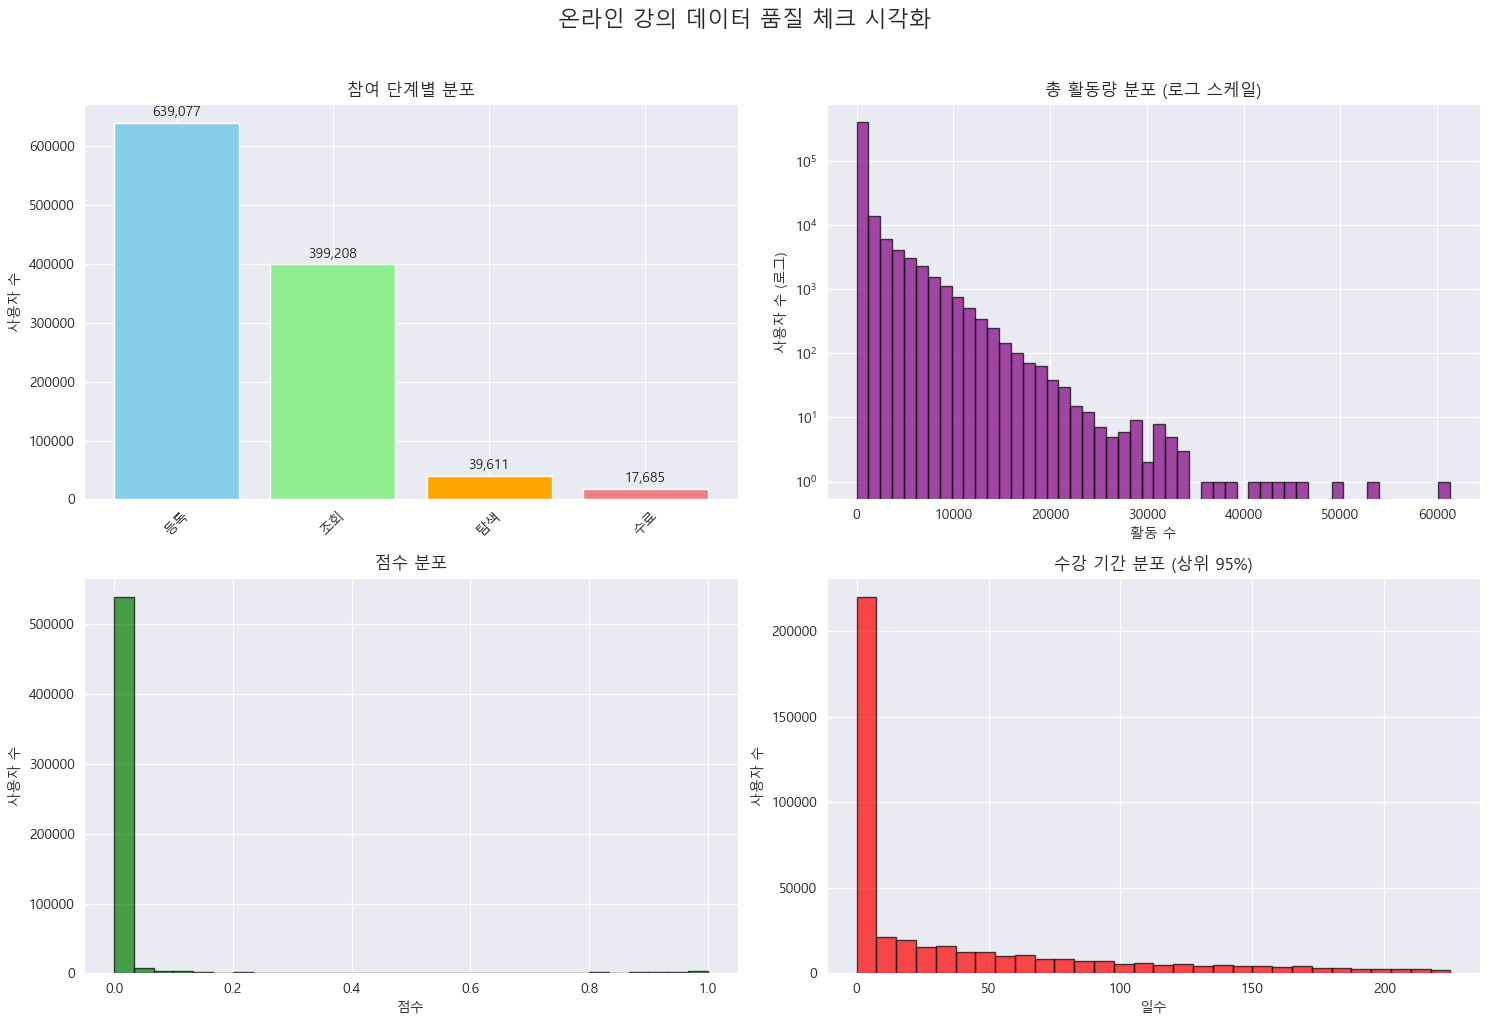

In [9]:
print("\n이상치 시각화")
print("-" * 40)

# 시각화 설정
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('온라인 강의 데이터 품질 체크 시각화', fontsize=16, y=1.02)

# 1. 참여 단계별 분포
participation_cols = ['registered', 'viewed', 'explored', 'certified']
participation_counts = [df[col].sum() for col in participation_cols]
participation_labels = ['등록', '조회', '탐색', '수료']

bars1 = axes[0,0].bar(participation_labels, participation_counts,
                      color=['skyblue', 'lightgreen', 'orange', 'lightcoral'])
axes[0,0].set_title('참여 단계별 분포')
axes[0,0].set_ylabel('사용자 수')
axes[0,0].tick_params(axis='x', rotation=45)

# 막대 위에 숫자 표시
for bar, count in zip(bars1, participation_counts):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(participation_counts)*0.01,
                   f'{count:,}', ha='center', va='bottom')

# 2. 총 활동량 분포 (로그 스케일)
axes[0,1].hist(df['nevents'], bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[0,1].set_yscale('log')
axes[0,1].set_title('총 활동량 분포 (로그 스케일)')
axes[0,1].set_xlabel('활동 수')
axes[0,1].set_ylabel('사용자 수 (로그)')

# 3. 점수 분포
valid_grades = df['grade'].dropna()
if len(valid_grades) > 0:
    axes[1,0].hist(valid_grades, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[1,0].set_title('점수 분포')
    axes[1,0].set_xlabel('점수')
    axes[1,0].set_ylabel('사용자 수')
else:
    axes[1,0].text(0.5, 0.5, '점수 데이터 없음', ha='center', va='center', transform=axes[1,0].transAxes)
    axes[1,0].set_title('점수 분포')

# 4. 수강 기간 분포 (상위 95%만 표시)
if 'course_duration' in df_time.columns:
    duration_data = df_time['course_duration'].dropna()
    if len(duration_data) > 0:
        duration_95 = duration_data.quantile(0.95)
        duration_filtered = duration_data[duration_data <= duration_95]

        axes[1,1].hist(duration_filtered, bins=30, alpha=0.7, color='red', edgecolor='black')
        axes[1,1].set_title('수강 기간 분포 (상위 95%)')
        axes[1,1].set_xlabel('일수')
        axes[1,1].set_ylabel('사용자 수')
    else:
        axes[1,1].text(0.5, 0.5, '유효한 기간 데이터 없음', ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('수강 기간 분포')

plt.tight_layout()
plt.show()


추가 시각화 1: 논리적 일관성 및 상관관계 분석
--------------------------------------------------


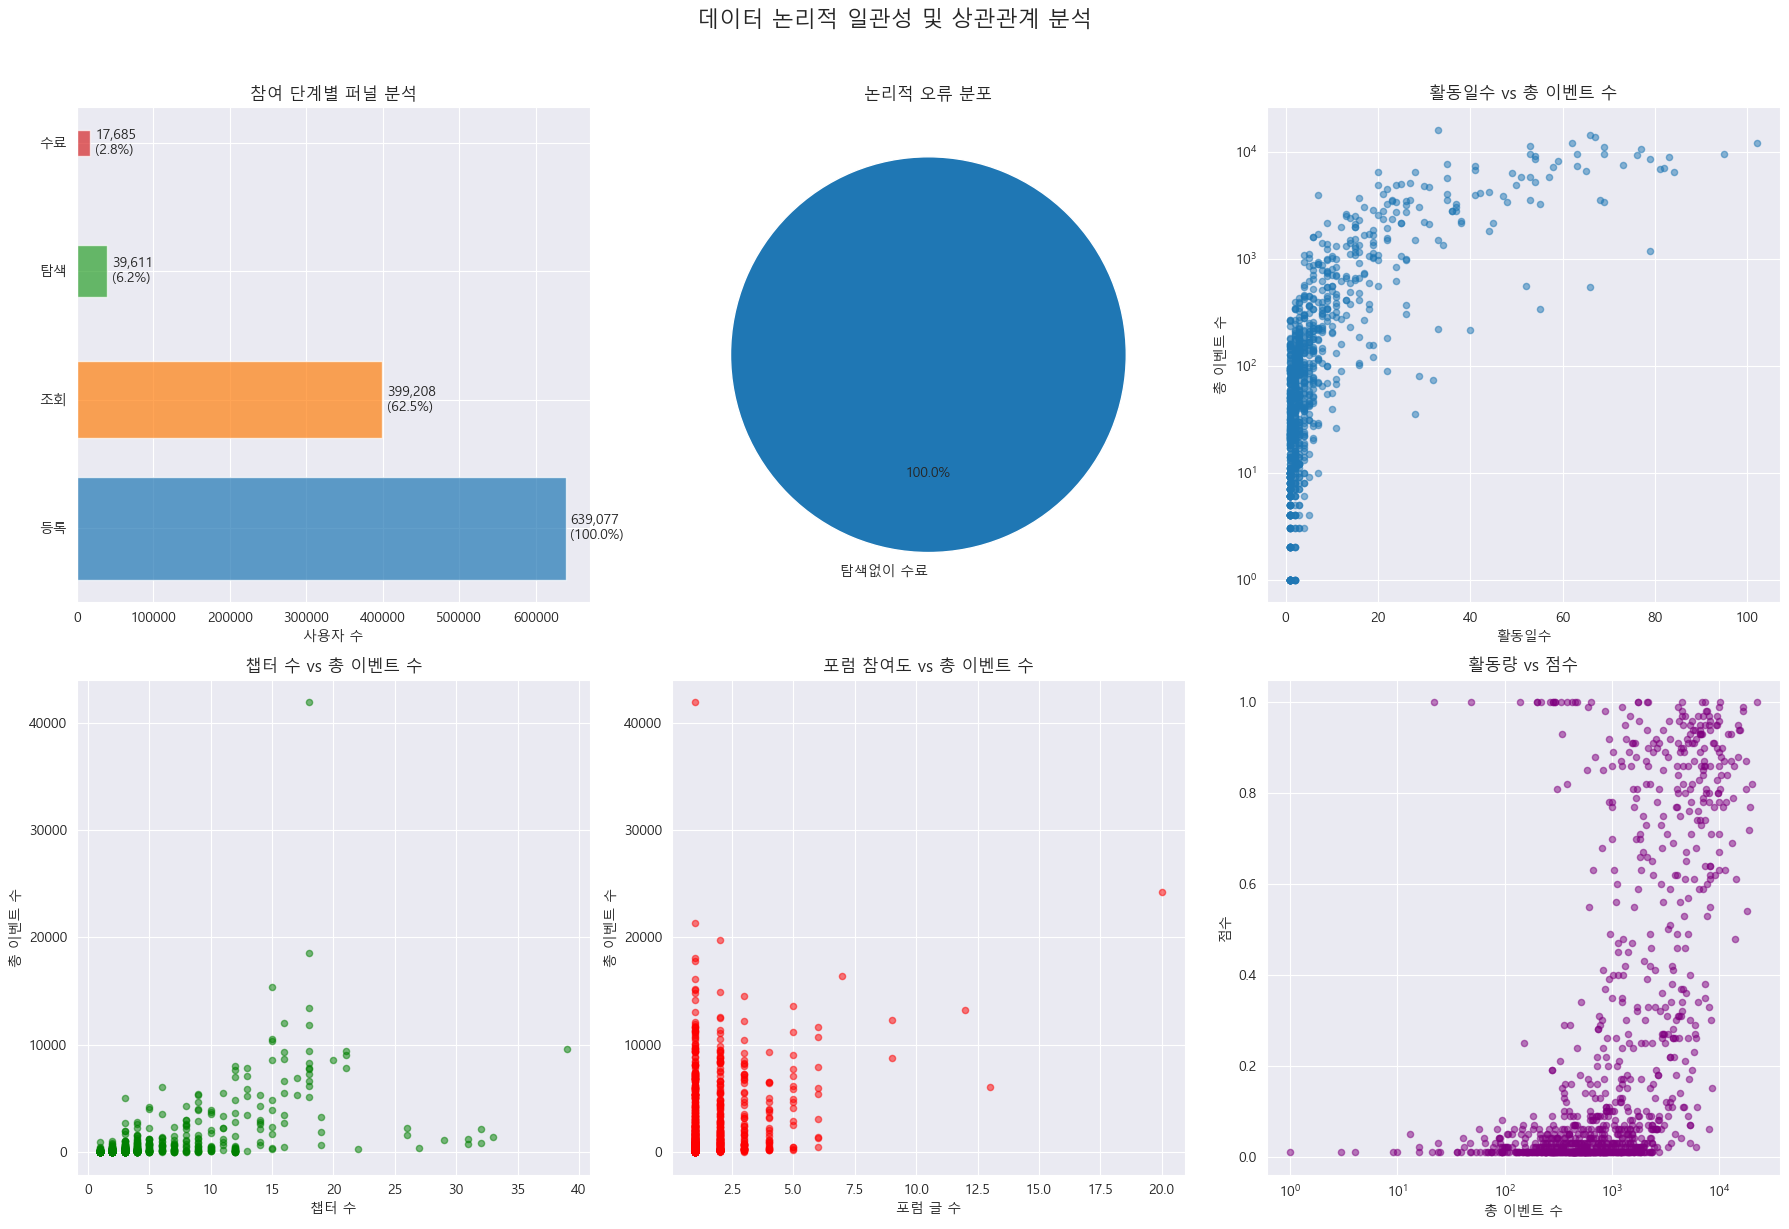

In [10]:
print("\n추가 시각화 1: 논리적 일관성 및 상관관계 분석")
print("-" * 50)

# 시각화 설정
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('데이터 논리적 일관성 및 상관관계 분석', fontsize=16, y=1.02)

# 1. 참여 단계별 전환율 퍼널 차트
participation_data = {
    '등록': df['registered'].sum(),
    '조회': df['viewed'].sum(),
    '탐색': df['explored'].sum(),
    '수료': df['certified'].sum()
}

stages = list(participation_data.keys())
counts = list(participation_data.values())
percentages = [100 * count / counts[0] for count in counts]

# 퍼널 형태로 막대 너비 조정
bar_widths = [0.8, 0.6, 0.4, 0.2]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

bars = axes[0,0].barh(range(len(stages)), counts, height=bar_widths, color=colors, alpha=0.7)
axes[0,0].set_yticks(range(len(stages)))
axes[0,0].set_yticklabels(stages)
axes[0,0].set_xlabel('사용자 수')
axes[0,0].set_title('참여 단계별 퍼널 분석')

# 퍼센트 표시
for i, (bar, count, pct) in enumerate(zip(bars, counts, percentages)):
    axes[0,0].text(bar.get_width() + max(counts)*0.01, bar.get_y() + bar.get_height()/2,
                   f'{count:,}\n({pct:.1f}%)', ha='left', va='center')

# 2. 논리적 오류 케이스 분포
error_data = {
    '등록없이 활동': issue_1,
    '조회없이 진행': issue_2,
    '탐색없이 수료': issue_3,
    '수료후 점수없음': issue_10
}

# 0이 아닌 값만 표시
error_data_filtered = {k: v for k, v in error_data.items() if v > 0}

if error_data_filtered:
    axes[0,1].pie(error_data_filtered.values(), labels=error_data_filtered.keys(),
                  autopct='%1.1f%%', startangle=90)
    axes[0,1].set_title('논리적 오류 분포')
else:
    axes[0,1].text(0.5, 0.5, '논리적 오류 없음', ha='center', va='center', transform=axes[0,1].transAxes)
    axes[0,1].set_title('논리적 오류 분포')

# 3. 활동량과 활동일수 관계
scatter_data = df[(df['nevents'] > 0) & (df['ndays_act'] > 0)].copy()
if len(scatter_data) > 1000:
    scatter_data = scatter_data.sample(1000)  # 성능을 위해 샘플링

axes[0,2].scatter(scatter_data['ndays_act'], scatter_data['nevents'], alpha=0.5, s=20)
axes[0,2].set_xlabel('활동일수')
axes[0,2].set_ylabel('총 이벤트 수')
axes[0,2].set_title('활동일수 vs 총 이벤트 수')
axes[0,2].set_yscale('log')

# 4. 챕터 수와 이벤트 수 관계
chapter_data = df[(df['nchapters'] > 0) & (df['nevents'] > 0)].copy()
if len(chapter_data) > 1000:
    chapter_data = chapter_data.sample(1000)

axes[1,0].scatter(chapter_data['nchapters'], chapter_data['nevents'], alpha=0.5, s=20, color='green')
axes[1,0].set_xlabel('챕터 수')
axes[1,0].set_ylabel('총 이벤트 수')
axes[1,0].set_title('챕터 수 vs 총 이벤트 수')

# 5. 포럼 참여도와 활동량 관계
forum_data = df[df['nforum_posts'] > 0].copy()
if len(forum_data) > 0:
    if len(forum_data) > 1000:
        forum_data = forum_data.sample(1000)

    axes[1,1].scatter(forum_data['nforum_posts'], forum_data['nevents'], alpha=0.5, s=20, color='red')
    axes[1,1].set_xlabel('포럼 글 수')
    axes[1,1].set_ylabel('총 이벤트 수')
    axes[1,1].set_title('포럼 참여도 vs 총 이벤트 수')
else:
    axes[1,1].text(0.5, 0.5, '포럼 데이터 없음', ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('포럼 참여도 vs 총 이벤트 수')

# 6. 점수와 활동량 관계
grade_data = df[(df['grade'].notna()) & (df['grade'] > 0) & (df['nevents'] > 0)].copy()
if len(grade_data) > 0:
    if len(grade_data) > 1000:
        grade_data = grade_data.sample(1000)

    axes[1,2].scatter(grade_data['nevents'], grade_data['grade'], alpha=0.5, s=20, color='purple')
    axes[1,2].set_xlabel('총 이벤트 수')
    axes[1,2].set_ylabel('점수')
    axes[1,2].set_title('활동량 vs 점수')
    axes[1,2].set_xscale('log')
else:
    axes[1,2].text(0.5, 0.5, '점수 데이터 없음', ha='center', va='center', transform=axes[1,2].transAxes)
    axes[1,2].set_title('활동량 vs 점수')

plt.tight_layout()


추가 시각화 2: 이상치 및 극단값 분석
--------------------------------------------------


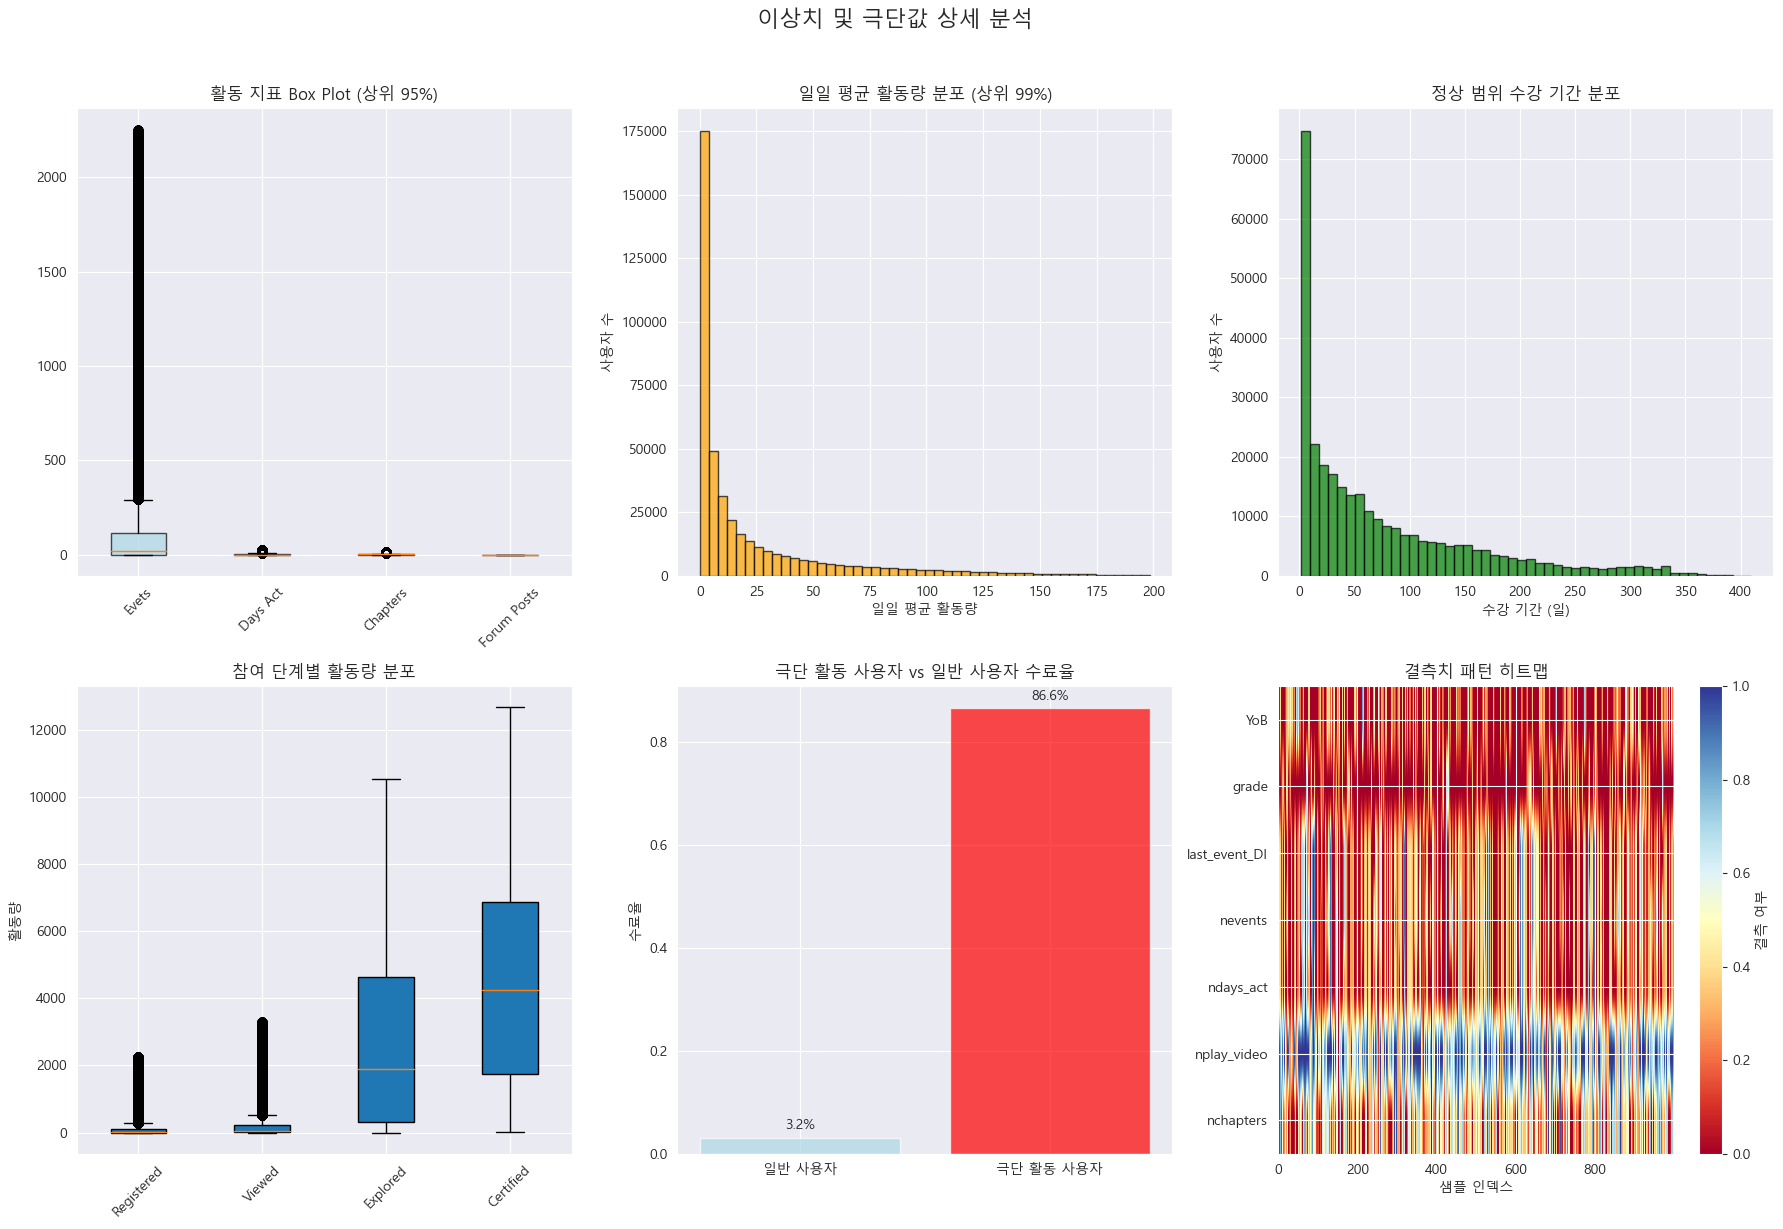

In [11]:
print("\n추가 시각화 2: 이상치 및 극단값 분석")
print("-" * 50)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('이상치 및 극단값 상세 분석', fontsize=16, y=1.02)

# 1. 활동량 Box Plot
numeric_cols = ['nevents', 'ndays_act', 'nchapters', 'nforum_posts']
activity_data = []
activity_labels = []

for col in numeric_cols:
    if col in df.columns:
        # 상위 95% 데이터만 사용 (극단값 제외하고 박스플롯 그리기)
        data = df[col].dropna()
        q95 = data.quantile(0.95)
        filtered_data = data[data <= q95]
        if len(filtered_data) > 0:
            activity_data.append(filtered_data)
            activity_labels.append(col.replace('n', '').replace('_', ' ').title())

if activity_data:
    box_plot = axes[0,0].boxplot(activity_data, labels=activity_labels, patch_artist=True)
    for patch in box_plot['boxes']:
        patch.set_facecolor('lightblue')
        patch.set_alpha(0.7)
    axes[0,0].set_title('활동 지표 Box Plot (상위 95%)')
    axes[0,0].tick_params(axis='x', rotation=45)

# 2. 일일 활동량 분포
daily_activity = df['nevents'] / (df['ndays_act'] + 1)  # 0으로 나누기 방지
daily_activity_filtered = daily_activity[daily_activity <= daily_activity.quantile(0.99)]

axes[0,1].hist(daily_activity_filtered, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[0,1].set_xlabel('일일 평균 활동량')
axes[0,1].set_ylabel('사용자 수')
axes[0,1].set_title('일일 평균 활동량 분포 (상위 99%)')

# 3. 시간 관련 이상치 시각화
if 'course_duration' in df_time.columns:
    duration_data = df_time['course_duration'].dropna()
    # 정상 범위 (1일 ~ 2년)
    normal_duration = duration_data[(duration_data >= 1) & (duration_data <= 730)]

    axes[0,2].hist(normal_duration, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[0,2].set_xlabel('수강 기간 (일)')
    axes[0,2].set_ylabel('사용자 수')
    axes[0,2].set_title('정상 범위 수강 기간 분포')

# 4. 참여도별 활동량 비교
participation_groups = []
group_labels = []

# 각 참여 단계별 활동량
for stage in ['registered', 'viewed', 'explored', 'certified']:
    if stage in df.columns:
        stage_data = df[df[stage] == True]['nevents']
        # 상위 95% 데이터만 사용
        stage_data_filtered = stage_data[stage_data <= stage_data.quantile(0.95)]
        if len(stage_data_filtered) > 0:
            participation_groups.append(stage_data_filtered)
            group_labels.append(stage.title())

if participation_groups:
    axes[1,0].boxplot(participation_groups, labels=group_labels, patch_artist=True)
    axes[1,0].set_ylabel('활동량')
    axes[1,0].set_title('참여 단계별 활동량 분포')
    axes[1,0].tick_params(axis='x', rotation=45)

# 5. 극단값 사용자 특성 분석
extreme_users = df[df['nevents'] > df['nevents'].quantile(0.99)].copy()

if len(extreme_users) > 0:
    # 극단값 사용자의 수료율
    if len(extreme_users) > 20:  # 충분한 데이터가 있을 때만
        extreme_certified_rate = extreme_users['certified'].mean()
        normal_users = df[df['nevents'] <= df['nevents'].quantile(0.99)]
        normal_certified_rate = normal_users['certified'].mean()

        rates = [normal_certified_rate, extreme_certified_rate]
        labels = ['일반 사용자', '극단 활동 사용자']

        bars = axes[1,1].bar(labels, rates, color=['lightblue', 'red'], alpha=0.7)
        axes[1,1].set_ylabel('수료율')
        axes[1,1].set_title('극단 활동 사용자 vs 일반 사용자 수료율')

        # 수치 표시
        for bar, rate in zip(bars, rates):
            axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{rate:.1%}', ha='center', va='bottom')
    else:
        axes[1,1].text(0.5, 0.5, '극단값 사용자\n데이터 부족', ha='center', va='center',
                       transform=axes[1,1].transAxes)
        axes[1,1].set_title('극단 활동 사용자 분석')

# 6. 결측치 패턴 히트맵
missing_data = df.isnull()
if missing_data.sum().sum() > 0:
    # 결측치가 있는 컬럼만 선택
    missing_cols = missing_data.columns[missing_data.sum() > 0]
    if len(missing_cols) > 0:
        # 샘플링 (너무 많으면 시각화가 어려움)
        sample_size = min(1000, len(df))
        sample_idx = np.random.choice(len(df), sample_size, replace=False)
        missing_sample = missing_data.iloc[sample_idx][missing_cols]

        im = axes[1,2].imshow(missing_sample.T, cmap='RdYlBu', aspect='auto')
        axes[1,2].set_yticks(range(len(missing_cols)))
        axes[1,2].set_yticklabels(missing_cols)
        axes[1,2].set_xlabel('샘플 인덱스')
        axes[1,2].set_title('결측치 패턴 히트맵')

        # 컬러바 추가
        plt.colorbar(im, ax=axes[1,2], label='결측 여부')
else:
    axes[1,2].text(0.5, 0.5, '결측치 없음', ha='center', va='center', transform=axes[1,2].transAxes)
    axes[1,2].set_title('결측치 패턴')

plt.tight_layout()
plt.show()


추가 시각화 3: 시간 패턴 및 데이터 품질 트렌드
--------------------------------------------------


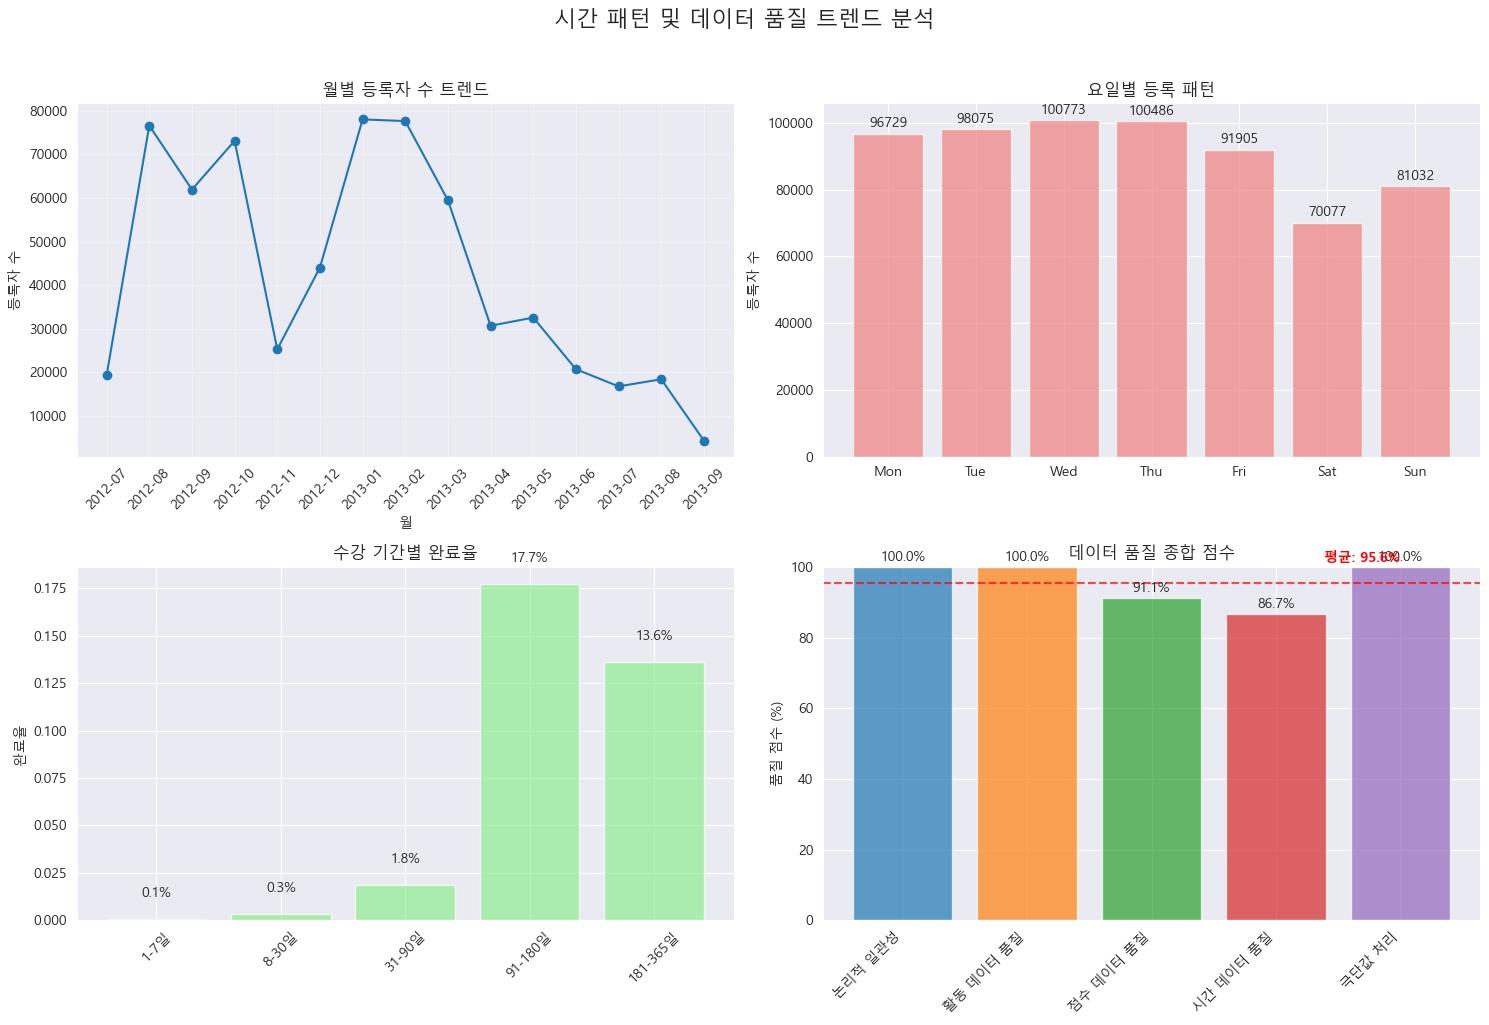


데이터 품질 종합 평가:
------------------------------
논리적 일관성: 100.0% (A)
활동 데이터 품질: 100.0% (A)
점수 데이터 품질: 91.1% (B)
시간 데이터 품질: 86.7% (C)
극단값 처리: 100.0% (A)

전체 평균 품질 점수: 95.6%


In [13]:
print("\n추가 시각화 3: 시간 패턴 및 데이터 품질 트렌드")
print("-" * 50)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('시간 패턴 및 데이터 품질 트렌드 분석', fontsize=16, y=1.02)

# 날짜 데이터 처리
df_time_analysis = df.copy()
df_time_analysis['start_time_DI'] = pd.to_datetime(df_time_analysis['start_time_DI'], errors='coerce')
df_time_analysis['last_event_DI'] = pd.to_datetime(df_time_analysis['last_event_DI'], errors='coerce')

# 1. 등록일별 사용자 수 트렌드
if df_time_analysis['start_time_DI'].notna().sum() > 0:
    daily_registrations = df_time_analysis['start_time_DI'].dt.date.value_counts().sort_index()

    if len(daily_registrations) > 50:  # 너무 많으면 월별로 집계
        monthly_registrations = df_time_analysis['start_time_DI'].dt.to_period('M').value_counts().sort_index()
        axes[0,0].plot(monthly_registrations.index.astype(str), monthly_registrations.values, marker='o')
        axes[0,0].set_title('월별 등록자 수 트렌드')
        axes[0,0].set_xlabel('월')
        axes[0,0].tick_params(axis='x', rotation=45)
    else:
        axes[0,0].plot(daily_registrations.index, daily_registrations.values, marker='o')
        axes[0,0].set_title('일별 등록자 수 트렌드')
        axes[0,0].set_xlabel('날짜')
        axes[0,0].tick_params(axis='x', rotation=45)

    axes[0,0].set_ylabel('등록자 수')
    axes[0,0].grid(True, alpha=0.3)

# 2. 요일별 활동 패턴
if df_time_analysis['start_time_DI'].notna().sum() > 0:
    df_time_analysis['start_weekday'] = df_time_analysis['start_time_DI'].dt.day_name()
    weekday_counts = df_time_analysis['start_weekday'].value_counts()

    # 요일 순서 정렬
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_counts = weekday_counts.reindex([day for day in weekday_order if day in weekday_counts.index])

    bars = axes[0,1].bar(range(len(weekday_counts)), weekday_counts.values, color='lightcoral', alpha=0.7)
    axes[0,1].set_xticks(range(len(weekday_counts)))
    axes[0,1].set_xticklabels([day[:3] for day in weekday_counts.index])
    axes[0,1].set_title('요일별 등록 패턴')
    axes[0,1].set_ylabel('등록자 수')

    # 막대 위에 숫자 표시
    for bar, count in zip(bars, weekday_counts.values):
        axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(weekday_counts)*0.01,
                       f'{count}', ha='center', va='bottom')

# 3. 수강 기간별 완료율
if 'course_duration' in df_time.columns:
    duration_data = df_time[df_time['course_duration'].between(1, 365)].copy()  # 1일~1년

    if len(duration_data) > 0:
        # 수강 기간을 구간별로 나누기
        duration_bins = [1, 7, 30, 90, 180, 365]
        duration_labels = ['1-7일', '8-30일', '31-90일', '91-180일', '181-365일']

        duration_data['duration_group'] = pd.cut(duration_data['course_duration'],
                                                bins=duration_bins, labels=duration_labels, right=False)

        completion_by_duration = duration_data.groupby('duration_group')['certified'].agg(['count', 'sum']).reset_index()
        completion_by_duration['completion_rate'] = completion_by_duration['sum'] / completion_by_duration['count']

        bars = axes[1,0].bar(range(len(completion_by_duration)), completion_by_duration['completion_rate'],
                            color='lightgreen', alpha=0.7)
        axes[1,0].set_xticks(range(len(completion_by_duration)))
        axes[1,0].set_xticklabels(completion_by_duration['duration_group'], rotation=45)
        axes[1,0].set_title('수강 기간별 완료율')
        axes[1,0].set_ylabel('완료율')

        # 완료율 표시
        for bar, rate in zip(bars, completion_by_duration['completion_rate']):
            axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                           f'{rate:.1%}', ha='center', va='bottom')

# 4. 데이터 품질 점수 (종합)
# 이전 셀에서 계산된 이상치 개수들을 다시 계산 (변수 참조 오류 방지)
critical_issues_count = issue_1 + issue_2 + issue_10 + issue_13
activity_issues_count = issue_4 + issue_5 + issue_6 + issue_7
grade_issues_count = issue_8 + issue_9 + issue_10
time_issues_count = issue_11 + issue_12 + issue_13
extreme_issues_count = issue_14 + issue_15 + issue_16 + issue_17

quality_metrics = {
    '논리적 일관성': max(0, 100 - (critical_issues_count / len(df) * 100)),
    '활동 데이터 품질': max(0, 100 - (activity_issues_count / len(df) * 100)),
    '점수 데이터 품질': max(0, 100 - (grade_issues_count / len(df) * 100)),
    '시간 데이터 품질': max(0, 100 - (time_issues_count / len(df) * 100)),
    '극단값 처리': max(0, 100 - (extreme_issues_count / len(df) * 100))
}

metrics = list(quality_metrics.keys())
scores = list(quality_metrics.values())

# 레이더 차트 효과를 위한 원형 막대 차트
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = axes[1,1].bar(range(len(metrics)), scores, color=colors, alpha=0.7)
axes[1,1].set_xticks(range(len(metrics)))
axes[1,1].set_xticklabels(metrics, rotation=45, ha='right')
axes[1,1].set_ylabel('품질 점수 (%)')
axes[1,1].set_title('데이터 품질 종합 점수')
axes[1,1].set_ylim(0, 100)

# 점수 표시
for bar, score in zip(bars, scores):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                   f'{score:.1f}%', ha='center', va='bottom')

# 평균 품질 점수 표시
avg_quality = np.mean(scores)
axes[1,1].axhline(y=avg_quality, color='red', linestyle='--', alpha=0.7)
axes[1,1].text(len(metrics)-1, avg_quality + 5, f'평균: {avg_quality:.1f}%',
               ha='right', va='bottom', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

# 품질 점수 요약 출력
print(f"\n데이터 품질 종합 평가:")
print("-" * 30)
for metric, score in quality_metrics.items():
    if score >= 95:
        grade = "A"
    elif score >= 90:
        grade = "B"
    elif score >= 80:
        grade = "C"
    elif score >= 70:
        grade = "D"
    else:
        grade = "F"
    print(f"{metric}: {score:.1f}% ({grade})")

print(f"\n전체 평균 품질 점수: {avg_quality:.1f}%")

# Cell 10: 전체 이상치 요약 및 결론

In [14]:
print("\n" + "=" * 60)
print("전체 이상치 요약")
print("=" * 60)

# 모든 이상치 수집
all_issues = {
    '등록하지 않았는데 활동': issue_1,
    '보지 않았는데 탐색/수료': issue_2,
    '탐색하지 않았는데 수료': issue_3,
    '활동일수 0인데 이벤트 있음': issue_4,
    '이벤트 0인데 챕터 수강': issue_5,
    '이벤트 0인데 포럼 글 작성': issue_6,
    '컨텐츠 봤는데 이벤트 0': issue_7,
    '수료 안했는데 점수 있음': issue_8,
    '수료했는데 점수 0': issue_9,
    '수료했는데 점수 NaN': issue_10,
    '활동일수가 수강기간보다 김': issue_11,
    '5년 이상 수강': issue_12,
    '음수 수강기간': issue_13,
    '일일 1000회 이상 활동': issue_14,
    '포럼 글 1000개 이상': issue_15,
    '챕터 500개 이상': issue_16,
    '총 이벤트 100000회 이상': issue_17
}

total_issues = sum(all_issues.values())
print(f"총 감지된 이상치: {total_issues:,}개")
print(f"전체 데이터 대비: {(total_issues/len(df)*100):.2f}%")

# 심각한 논리적 오류 (비즈니스 로직상 말이 안 되는 것들)
critical_issues = {
    '등록하지 않았는데 활동': issue_1,
    '보지 않았는데 탐색/수료': issue_2,
    '수료했는데 점수 NaN': issue_10,
    '음수 수강기간': issue_13
}

critical_total = sum(critical_issues.values())
print(f"\n심각한 논리적 오류: {critical_total:,}개")

if critical_total > 0:
    print("심각한 오류 상세:")
    for issue, count in critical_issues.items():
        if count > 0:
            pct = (count / len(df)) * 100
            print(f"  - {issue}: {count:,}개 ({pct:.2f}%)")

# 개선 권고사항
print(f"\n개선 권고사항:")
print("1. 데이터 수집 시 참여 단계의 논리적 순서 검증 로직 추가")
print("2. 활동 데이터 입력 시 일관성 체크 기능 구현")
print("3. 극단적 이상치에 대한 자동 탐지 및 검토 프로세스 도입")
print("4. 정기적인 데이터 품질 모니터링 대시보드 구축")

# 데이터 신뢰도 점수 계산
clean_records = len(df) - critical_total
reliability_score = (clean_records / len(df)) * 100
print(f"\n데이터 신뢰도 점수: {reliability_score:.2f}%")

if reliability_score >= 95:
    quality_level = "매우 우수"
elif reliability_score >= 90:
    quality_level = "우수"
elif reliability_score >= 85:
    quality_level = "양호"
elif reliability_score >= 80:
    quality_level = "보통"
else:
    quality_level = "개선 필요"

print(f"데이터 품질 등급: {quality_level}")


전체 이상치 요약
총 감지된 이상치: 142,625개
전체 데이터 대비: 22.32%

심각한 논리적 오류: 0개

개선 권고사항:
1. 데이터 수집 시 참여 단계의 논리적 순서 검증 로직 추가
2. 활동 데이터 입력 시 일관성 체크 기능 구현
3. 극단적 이상치에 대한 자동 탐지 및 검토 프로세스 도입
4. 정기적인 데이터 품질 모니터링 대시보드 구축

데이터 신뢰도 점수: 100.00%
데이터 품질 등급: 매우 우수


# Cell 11: 이상치 데이터 별도 저장

In [15]:
# 심각한 이상치가 포함된 레코드들을 별도 파일로 저장
anomaly_mask = (
    no_register_but_active |
    no_view_but_advanced |
    certified_but_grade_nan |
    negative_duration
)

if anomaly_mask.sum() > 0:
    anomaly_df = df[anomaly_mask].copy()

    # 이상치 타입 컬럼 추가
    anomaly_df['anomaly_type'] = ''
    anomaly_df.loc[no_register_but_active, 'anomaly_type'] += '등록없이활동;'
    anomaly_df.loc[no_view_but_advanced, 'anomaly_type'] += '조회없이진행;'
    anomaly_df.loc[certified_but_grade_nan, 'anomaly_type'] += '수료후점수없음;'
    anomaly_df.loc[negative_duration, 'anomaly_type'] += '음수수강기간;'

    # 세미콜론 제거
    anomaly_df['anomaly_type'] = anomaly_df['anomaly_type'].str.rstrip(';')

    # 파일 저장
    anomaly_file_path = "data_quality_anomalies.csv"
    anomaly_df.to_csv(anomaly_file_path, index=False, encoding='utf-8-sig')

    print(f"\n이상치 데이터 {len(anomaly_df):,}건을 '{anomaly_file_path}' 파일로 저장했습니다.")
    print("이상치 타입별 분포:")

    # 이상치 타입별 집계
    anomaly_types = anomaly_df['anomaly_type'].str.split(';').explode().value_counts()
    for atype, count in anomaly_types.items():
        print(f"  {atype}: {count:,}건")
else:
    print("\n저장할 심각한 이상치가 없습니다.")


저장할 심각한 이상치가 없습니다.

데이터 품질 체크가 완료되었습니다.


온라인 강의 데이터 품질 및 논리적 일관성 체크
============================================================
데이터 로드: (639086, 20)
1. 참여 단계 논리적 순서 체크
----------------------------------------
등록하지 않았는데 활동한 경우: 0개
보지 않았는데 탐색/수료한 경우: 8개 -- 삭제 필요
탐색하지 않았는데 수료한 경우: 690개 -- 그럴 수 있음

2. 활동 데이터 일관성 체크
----------------------------------------
활동일수 0인데 이벤트가 있는 경우: 0개
이벤트 0인데 챕터 수강한 경우: 0개
이벤트 0인데 포럼 글 작성한 경우: 46개 -- 그럴 수 있음
컨텐츠를 봤는데 이벤트가 0인 경우: 0개

3. 점수와 수료 상태 일관성 체크
----------------------------------------
수료하지 않았는데 점수가 있는 경우: 56,599개 -- fail 점수 예상
수료했는데 점수가 0인 경우: 1개 -- 이상하긴 하지만 점수로 수료 가능한 강의가 아닐 수 도
수료했는데 점수가 NaN인 경우: 0개

4. 시간 관련 이상치 체크
----------------------------------------
활동일수가 수강기간보다 긴 경우: 85,266개 - 활동을 더 오래한 사람?
5년 이상 수강한 경우: 0개
음수 수강기간: 0개

수강기간 통계:
   평균: 50.9일
   중간값: 11.0일
   최대값: 409일

5. 극단적 이상치 체크
----------------------------------------
일일 1000회 이상 활동한 경우: 24개
포럼 글 1000개 이상 작성한 경우: 0개
챕터 500개 이상 수강한 경우: 0개
총 이벤트 100000회 이상인 경우: 1개

활동량 상위 1% 통계:
   상위 1% 기준값: 7868회
   최대값: 197,757.0회 -- 상위 1%로 대체

6. 결측치 패턴 분석
----------------------------------------
전체 결측치 비율: 10.25% - 문제 없어 보임.

결측치가 있는 컬럼:
   grade: 56,742개 (8.9%)
   last_event_DI: 178,625개 (28.0%)
   nevents: 198,714개 (31.1%)
   ndays_act: 162,431개 (25.4%)
   nplay_video: 455,824개 (71.3%)
   nchapters: 257,711개 (40.3%)

모든 값이 결측인 행: 0개